# Objective

* Make a baseline model that predict the validation (28 days). 
* This competition has 2 stages, so the main objective is to make a model that can predict the demand for the next 28 days

## Introduction:
Hi everyone welcome to this kernel,In this kernel i am building basic LightGBM model on timeseriessplits.This notebook was build on top of this [kernel](https://www.kaggle.com/ragnar123/very-fst-model).Thanks to the author of the kernel [ragnar](https://www.kaggle.com/ragnar123) <br>
### <font color='red'>If you find this kernel useful please consider upvoting 😊 It will keep me motivated to produce more quality content.Also dont forget to upvote the original kernel.</font>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import dask_xgboost as xgb
import dask.dataframe as dd
from sklearn import preprocessing, metrics
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
import gc
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# function to read the data and merge it (ignoring some columns, this is a very fst model)


def read_data():
    print('Reading files...')
    calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    submission = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv')
    return calendar, sell_prices, sales_train_validation, submission


def melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 55000000, merge = False):
    
    # melt sales data, get it ready for training
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    # seperate test dataframes
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # change column names
    test1.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931', 
                      'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941']
    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
    
    # get product table
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # merge with product table
    test1 = test1.merge(product, how = 'left', on = 'id')
    test2 = test2.merge(product, how = 'left', on = 'id')
    
    # 
    test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    sales_train_validation['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'
    
    data = pd.concat([sales_train_validation, test1, test2], axis = 0)
    
    del sales_train_validation, test1, test2
    
    # get only a sample for fst training
    data = data.loc[nrows:]
    
    # drop some calendar features
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    
    # delete test2 for now
    data = data[data['part'] != 'test2']
    
    if merge:
        # notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d', 'day'], inplace = True, axis = 1)
        # get the sell price data (this feature should be very important)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    gc.collect()
    
    return data
        
calendar, sell_prices, sales_train_validation, submission = read_data()
data = melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 27500000, merge = True)
gc.collect()

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to 3226.27 Mb (9.4% reduction)
Our final dataset to train has 31681090 rows and 18 columns


0

In [3]:
def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
    
    encoder = preprocessing.LabelEncoder()
    data['id_encode'] = encoder.fit_transform(data['id'])
    
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data

data = transform(data)
gc.collect()
def simple_fe(data):
    
    # demand features
    data['lag_t28'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    data['lag_t29'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(29))
    data['lag_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(30))
    data['rolling_mean_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    data['rolling_std_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    data['rolling_mean_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    data['rolling_mean_t90'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    data['rolling_mean_t180'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    data['rolling_std_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
    
    # price features
    data['lag_price_t1'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
    data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1'])
    data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
    data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
    data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)
    
    # time features
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['week'] = data['date'].dt.week
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    
    return data

In [4]:
data = simple_fe(data)
data = reduce_mem_usage(data)
gc.collect()

Mem. usage decreased to 2568.14 Mb (65.6% reduction)


55

In [5]:
x = data[data['date'] <= '2016-04-24']
y = x.sort_values('date')['demand']
test = data[(data['date'] > '2016-04-24')]
x = x.sort_values('date')
test = test.sort_values('date')
del data

In [6]:
n_fold = 3 #3 for timely purpose of the kernel
folds = TimeSeriesSplit(n_splits=n_fold)

In [7]:
params = {'num_leaves': 555,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'regression',
          'max_depth': -1,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 222,
         }

In [8]:
columns = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'year', 'month', 'week', 'day', 'dayofweek', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
            'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7', 'rolling_mean_t30', 'rolling_mean_t90', 
            'rolling_mean_t180', 'rolling_std_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30']
splits = folds.split(x, y)
y_preds = np.zeros(test.shape[0])
y_oof = np.zeros(x.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
mean_score = []
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = x[columns].iloc[train_index], x[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    clf = lgb.train(params, dtrain, 2500, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=100)
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
    y_oof[valid_index] = y_pred_valid
    val_score = np.sqrt(metrics.mean_squared_error(y_pred_valid, y_valid))
    print(f'val rmse score is {val_score}')
    mean_score.append(val_score)
    y_preds += clf.predict(test[columns], num_iteration=clf.best_iteration)/n_fold
    del X_train, X_valid, y_train, y_valid
    gc.collect()
print('mean rmse score over folds is',np.mean(mean_score))
test['demand'] = y_preds

Fold: 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3.49298	valid_1's rmse: 3.04389
[200]	training's rmse: 3.12241	valid_1's rmse: 2.70715
[300]	training's rmse: 2.92076	valid_1's rmse: 2.5591
[400]	training's rmse: 2.81338	valid_1's rmse: 2.4917
[500]	training's rmse: 2.7374	valid_1's rmse: 2.45977
[600]	training's rmse: 2.68321	valid_1's rmse: 2.44428
[700]	training's rmse: 2.64118	valid_1's rmse: 2.43581
[800]	training's rmse: 2.6077	valid_1's rmse: 2.43205
[900]	training's rmse: 2.57645	valid_1's rmse: 2.43066
Early stopping, best iteration is:
[879]	training's rmse: 2.58312	valid_1's rmse: 2.43019
val rmse score is 2.430193069573429
Fold: 2
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3.23723	valid_1's rmse: 2.87286
[200]	training's rmse: 2.86907	valid_1's rmse: 2.56752
[300]	training's rmse: 2.6844	valid_1's rmse: 2.42999
[400]	training's rmse: 2.58899	valid_1's rmse: 2.36913
[500]	training's rmse: 2.5

In [9]:
def predict(test, submission):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]
    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    #final.to_csv('submission.csv', index = False)
    return final

subs = predict(test, submission)
subs.to_csv('submission.csv',index = False)
subs.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.821278,0.733072,0.700000,0.682407,0.740012,0.886521,0.915310,0.714042,0.867104,0.905093,0.919267,0.993613,1.226461,1.200425,0.919032,0.768374,0.733976,0.741290,0.846195,1.226244,1.073769,0.832778,0.776443,0.789733,0.879420,0.877995,1.071981,1.079419
1,HOBBIES_1_002_CA_1_validation,0.352776,0.306027,0.293160,0.282297,0.307996,0.337980,0.329734,0.233463,0.210957,0.188940,0.169747,0.212495,0.261945,0.249969,0.184294,0.168030,0.167081,0.167648,0.194681,0.245270,0.243427,0.180940,0.163518,0.231882,0.215873,0.240591,0.274105,0.266476
2,HOBBIES_1_003_CA_1_validation,0.465692,0.433921,0.432760,0.428892,0.462980,0.574062,0.644539,0.364606,0.338533,0.313525,0.304026,0.352846,0.429492,0.389680,0.307468,0.282724,0.324633,0.393922,0.546666,0.696570,0.840781,0.615676,0.600061,0.592991,0.525085,0.586661,0.743231,0.687585
3,HOBBIES_1_004_CA_1_validation,1.871345,1.531452,1.419753,1.333988,1.709644,2.016463,2.116181,1.636783,1.690067,1.526025,1.332329,1.689945,2.441631,2.453563,2.010884,1.658993,1.778170,1.663464,1.845743,2.088393,2.380668,1.958115,1.698099,1.508174,1.499530,1.822684,2.630941,2.540950
4,HOBBIES_1_005_CA_1_validation,0.821126,0.705750,0.886493,1.042970,1.050062,1.271438,1.572479,1.140702,1.136852,0.936065,0.851097,1.007796,1.289913,1.132837,0.994678,0.884598,0.897411,0.904040,1.057359,1.312177,1.281571,0.876268,0.858150,0.867887,0.896090,1.032449,1.318858,1.536427


## Feature Importances:

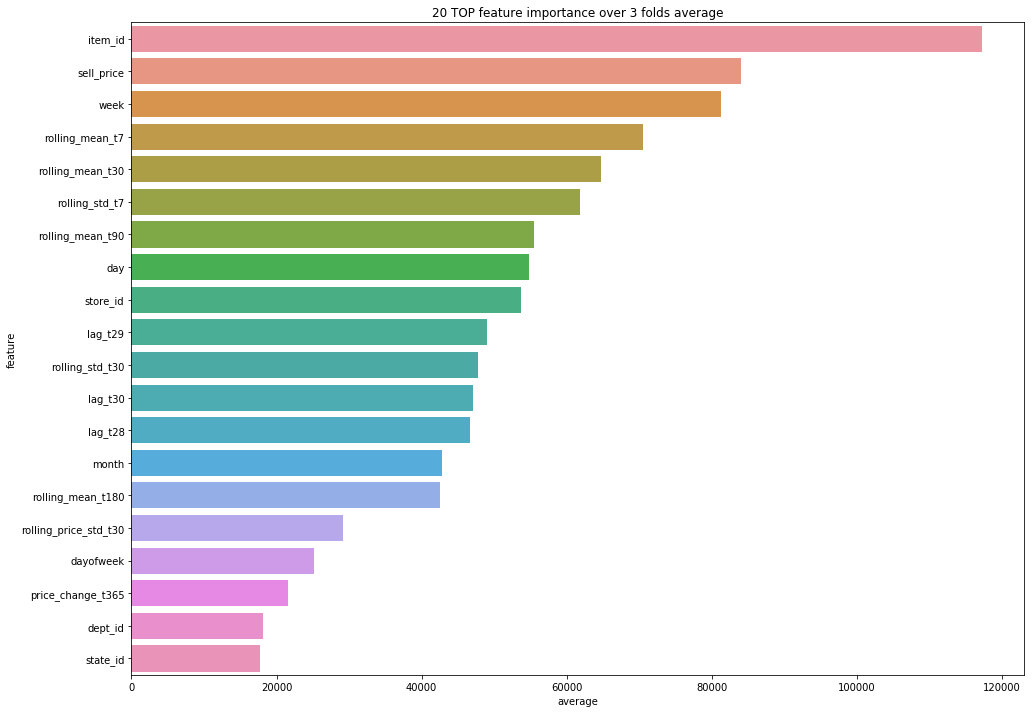

In [10]:
import seaborn as sns
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature');
plt.title('20 TOP feature importance over {} folds average'.format(folds.n_splits));